# NEOPRENE notebooks

***

This notebook is part of a notebook collection available at the [NEOPRENE Project Site](https://github.com/IHCantabria/NEOPRENE) for illustration, reproducibility and reusability purposes. This notebook is licensed under the [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0).

![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

# Calibrating and synthetic simulations of Rainfall with the STNSRPM.


In this script we calibrate the STNSRPM (Spatio Temporal Neyman Scott Rectangular Pulse Model) using several rainfall series from the Asón river basin in northern Spain. The calibration parameters are used to simulate several decades of synthetic rainfall data which can be very useful for rainfall extreme analysis or disaggregation purposes, among other things.

The script also contains:

1. a validation section where the observed series are compared with the simulated ones in terms of their statistics and exceedance probabilities. 

2. a disaggregation function to disaggreate daily to hourly rainfall data.

<font color='red'>Please, be advised that some of the processes may take up to 20 minutes in a modern computer.</font>

### Load packages

In [11]:
%load_ext autoreload
%autoreload 2

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapefile as shp

In [13]:
from NEOPRENE.STNSRP.HiperParams import Calibration as Calhps, Simulation as Simhps
from NEOPRENE.STNSRP.Statistics import Statistics
from NEOPRENE.STNSRP.utils import compare_statistics, datetime2matlabdnJavi 
from NEOPRENE.STNSRP.Calibration import Calibration
from NEOPRENE.STNSRP.MathematicalPropertiesSTNSRP import STNSRP_fi_min
from NEOPRENE.NSRP.Simulation import Simulation as Simulation_NSRP
from NEOPRENE.STNSRP.Simulation import Simulation

In [14]:
import warnings
warnings.filterwarnings('ignore')

## Example 1. Calibration and validation of daily data

### Loading daily rainfall for Asón river basin

<font color='red'>__It is important that there is no time series that has precipitation values in a time period that does not exist in the rest of the stations.__</font>

In [15]:
Series_Ason = pd.read_csv('auxiliary-materials/Ason/Inventario_Seriestemporales.csv', index_col=0, parse_dates=True)
Series_Ason[Series_Ason.values<0]=np.nan
Input_Series=Series_Ason.copy()

### Loading attributes for the series

In [16]:
Attributes_Ason= pd.read_csv('auxiliary-materials/Ason/Inventario_Atributos.csv')
Input_Attr=pd.DataFrame()
Input_Attr['ID']=Attributes_Ason.Id
Input_Attr['X']=Attributes_Ason.Longitud.values
Input_Attr['Y']=Attributes_Ason.Latitud.values
Input_Attr['Elevation']=Attributes_Ason.Height.values

### Shorting ID series to match with Input_Attr

In [17]:
Input_Series = Input_Series[Input_Attr.ID]

### Plotting rainfall series, seasonality

Text(0, 0.5, 'mm/month')

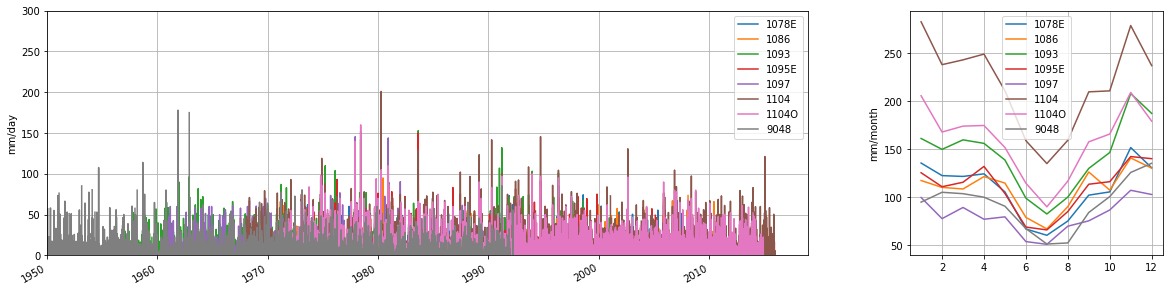

In [18]:
f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(20, 5))

t1=str(Input_Series.index.year[0]); t2=str(Input_Series.index.year[-1])
Input_Series.plot(xlim=(t1, t2),  ylim=(0, 300), ax = ax0)
ax0.grid(True)
ax0.set_ylabel('mm/day')

grouped_m = Input_Series.groupby(lambda x: x.month)
Month_sum=grouped_m.sum()*24/(len(Input_Series>=0)/30)
Month_sum.plot(ax = ax1)
ax1.grid(True)
ax1.set_ylabel('mm/month')

### Plotting gauge position

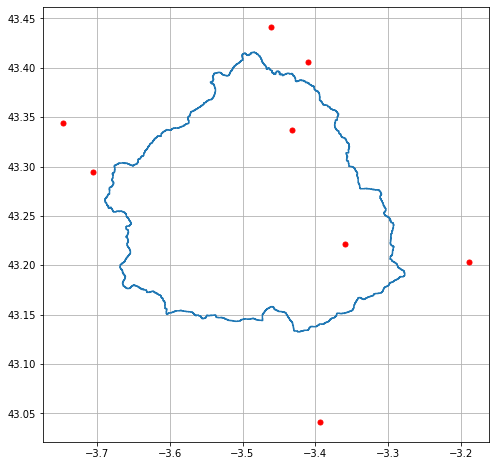

In [19]:
sf = shp.Reader("auxiliary-materials/Ason/Subbasin_WGS84.shp")

fig, ax = plt.subplots(figsize=(8, 8))
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    ax.plot(x,y)
ax.plot(Input_Attr.X, Input_Attr.Y, '.r',markersize=10)
ax.grid()

### Calibration

The calibration input file ([Input_Cal_Ason.yml](https://github.com/IHCantabria/NEOPRENE/blob/main/notebooks/Input_Cal_Ason.yml)) contains the hyperparameters to calibrate the model. This hyperparameters are loaded by the ```Calibration``` class within the ```NEOPRENE.STNSRP.HiperParams``` module. In this notebook, the module is loaded as ```Calhps```.

Input rainfall statistics can be directly calculated by the software from a time series or can be introduced from a file with the statistics (both options are shown in the present notebook).

A description of the hyperparamters available in the calibration file ([Input_Cal_Ason.yml](https://github.com/IHCantabria/NEOPRENE/blob/main/notebooks/Input_Cal_Ason.yml)) can be found within the ```doc``` folder of the [project repository](https://github.com/IHCantabria/NEOPRENE).

In [32]:
# Reading hiperparamteres for the calibration
hiper_params_cal = Calhps('./Input_Cal_Ason.yml')

The original time series statistics are computed first, as the model calibrates against those statistics. Once the statistics have been computed, the library does not need the complete time series anymore.

In [27]:
# Input statistics calculated from several Rainfall series
statistics_model_1 = Statistics(hiper_params_cal, time_series = Input_Series, attributes = Input_Attr)

# Input statistics from file 
statistics_model_2 = Statistics(hiper_params_cal, files_folder = './statistics_Ason/')

The hyperparameters are passed to the Calibration class which return a calibrator object. This object can be used as a function, that receives the statistics that need to be reproduced by the model. The object can also save the calibrated parameters to disk for later use.

In [ ]:
CAL              = Calibration(hiper_params_cal) 
CAL1             = CAL(statistics_model_1, Input_Series, verbose=True)
os.makedirs('./ASON/CAL1/',exist_ok=True)
CAL1.save_files('./ASON/CAL1/') #save python objects



################################################################################
Adjustment of parameters using the Particle Swarm Optimization (PSO)



Fitting the months = (1, 2, 3)

Initialization number  = 0
Initial best position  2.2397743868334263 [1.40475998e-01 2.63906786e+01 1.09777238e+03 1.19374968e+00
 5.97381781e-01]
Iteration number  = 0
Total error = 2.2397743868334263
Iteration number  = 1
Total error = 2.2397743868334263
Iteration number  = 2
Total error = 2.0946334738101355
Iteration number  = 3
Total error = 1.7579471297543388
Iteration number  = 4
Total error = 1.7579471297543388
Iteration number  = 5
Total error = 1.7483114683678922
Iteration number  = 6
Total error = 1.6005280634713979
Iteration number  = 7
Total error = 1.581281248238671
Iteration number  = 8
Total error = 1.5435150611398782
Iteration number  = 9
Total error = 1.3433575638818358
Iteration number  = 10
Total error = 1.1611322109213447
Iteration number  = 11
Total error = 0.8201278887420815
Itera

### Simulation

The input simulation file ([Input_Sim_Ason.yml](https://github.com/IHCantabria/NEOPRENE/blob/main/notebooks/Input_Sim_Ason.yml)) contains the hypermarametes for rainfall simulation.

A description of the hyperparamters available in the simulation file ([Input_Sim_Ason.yml](https://github.com/IHCantabria/NEOPRENE/blob/main/notebooks/Input_Sim_Ason.yml)) can be found within the ```doc``` folder of the [project repository](https://github.com/IHCantabria/NEOPRENE).

The first thing we do is to load the hyperparameters

In [17]:
# Reading hiperparamteres for the simulation
hiper_params_sim = Simhps('./Input_Sim_Ason.yml')

And those hyperparameters are then used to configure the Simulation class, which return a Simulation object that is used in a very similar way to the Calibration object.

In [18]:
SIM              = Simulation(hiper_params_sim) 
# Input parameters from the model

SIM1             = SIM(params_cal = CAL1, Input_Series = Input_Series, Input_Attr = Input_Attr)

#SIM1             = SIM(params_cal =['./CAL3/Calibrated_parameters.csv',
#                                    './CAL3/xi_months.csv'], 
#                       Input_Series = Input_Series, Input_Attr = Input_Attr)

os.makedirs('./ASON/SIM1/',exist_ok=True)
SIM1.save_files('./ASON/SIM1/')



################################################################################
Synthetic simulation


Simulation corners: 
 xp: [-4.098909920462989, -2.8368900795370102, -2.8368900795370102, -4.098909920462989]
 yp:[42.68859007953701, 42.68859007953701, 43.79420992046299, 43.79420992046299]
Simulation area (km²):12681.066463799076
Cells per storm per km²: 
[0.01912673 0.01912673 0.01912673 0.01344035 0.01344035 0.01344035
 0.01362482 0.01362482 0.01362482 0.02194577 0.02194577 0.02194577]
Cells per storm in my simulation area: 
[242.54738024 242.54738024 242.54738024 170.43799385 170.43799385
 170.43799385 172.7771921  172.7771921  172.7771921  278.29574199
 278.29574199 278.29574199]
Number of storms 790 for the months (1, 2, 3)
Number of rain cells per storm 244.39113924050633


100%|████████████████████████████████████████████████████████████████████████████████| 790/790 [02:12<00:00,  5.98it/s]


Number of storms 811 for the months (4, 5, 6)
Number of rain cells per storm 243.90258939580764


100%|████████████████████████████████████████████████████████████████████████████████| 811/811 [02:01<00:00,  6.70it/s]


Number of storms 775 for the months (7, 8, 9)
Number of rain cells per storm 242.76903225806453


100%|████████████████████████████████████████████████████████████████████████████████| 775/775 [01:51<00:00,  6.94it/s]


Number of storms 819 for the months (10, 11, 12)
Number of rain cells per storm 171.55433455433456


100%|████████████████████████████████████████████████████████████████████████████████| 819/819 [01:22<00:00,  9.94it/s]


In [19]:
SIM1.save_files('./SIM3/')

In [20]:
Input_Series.corr()

,1078E,1086,1093,1095E,1097,1104,1104O,9048
1078E,1.000000,0.704461,0.825059,0.808781,0.655836,0.770729,0.782941,0.626929
1086,0.704461,1.000000,0.676707,0.810983,0.788459,0.725382,0.786310,0.478244
1093,0.825059,0.676707,1.000000,0.781746,0.586937,0.755506,0.775756,0.559747
1095E,0.808781,0.810983,0.781746,1.000000,0.740343,0.825176,0.856987,0.516824
1097,0.655836,0.788459,0.586937,0.740343,1.000000,0.655470,0.754681,0.396576
1104,0.770729,0.725382,0.755506,0.825176,0.655470,1.000000,0.891269,0.554421
1104O,0.782941,0.786310,0.775756,0.856987,0.754681,0.891269,1.000000,0.542310
9048,0.626929,0.478244,0.559747,0.516824,0.396576,0.554421,0.542310,1.000000


In [21]:
SIM1.Daily_Simulation.astype(float).corr()

,1078E,1086,1093,1095E,1097,1104,1104O,9048
1078E,1.000000,0.543950,0.650239,0.585765,0.535417,0.517742,0.516895,0.573904
1086,0.543950,1.000000,0.595210,0.679842,0.691786,0.549760,0.562394,0.533773
1093,0.650239,0.595210,1.000000,0.643612,0.585070,0.579346,0.562886,0.621962
1095E,0.585765,0.679842,0.643612,1.000000,0.660405,0.607761,0.587246,0.570950
1097,0.535417,0.691786,0.585070,0.660405,1.000000,0.570911,0.585618,0.533557
1104,0.517742,0.549760,0.579346,0.607761,0.570911,1.000000,0.691572,0.540851
1104O,0.516895,0.562394,0.562886,0.587246,0.585618,0.691572,1.000000,0.527395
9048,0.573904,0.533773,0.621962,0.570950,0.533557,0.540851,0.527395,1.000000


In [22]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 2141.9579808712006 seconds ---
